# Introduction to Data Science

## Statistical Inference -- Part 2

In [2]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

In [3]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    folder = '../../datasets/ebay_boys_girls_shirts/'
    x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

In [4]:
folder = '../../datasets/ebay_boys_girls_shirts/'

# the function get_images_matrix was previously defined
boys_sample = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n = 30, seed = 1976)
girls_sample = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n = 30, seed = 1976)

boys_red = boys_sample[:, :, :, 0].mean(axis = (1, 2))
girls_red = girls_sample[:, :, :, 0].mean(axis = (1, 2))

print(boys_red[:10])
print(girls_red[:10])

[206.6873 142.7775 200.6834 221.9937 176.6418  50.4814 160.1469 121.421
 216.0849 204.6111]
[ 38.0923 179.1978 216.0276 224.2833 129.7951 113.9222 114.0983 250.197
 241.1484 202.9927]


In [5]:
boys_all = get_images_matrix(folder + 'boys_train.csv', folder + 'boys')
girls_all = get_images_matrix(folder + 'girls_train.csv', folder + 'girls')

boys_red_all = boys_all[:, :, :, 0].mean(axis = (1, 2))
girls_red_all = girls_all[:, :, :, 0].mean(axis = (1, 2))
population = np.concatenate([boys_red_all, girls_red_all])

print(population.shape)

(20000,)


In [7]:
def sample_null_mean_diff(n = 30):
    boys_red_null = np.random.choice(population, n)
    girls_red_null = np.random.choice(population, n)
    return girls_red_null.mean() - boys_red_null.mean()
null_mean_diffs = np.array([sample_null_mean_diff() for i in range(10000)])

print(f'Max null mean diff: {max(null_mean_diffs): .2f}')
print(f'Min null mean diff: {min(null_mean_diffs): .2f}')

Max null mean diff:  48.47
Min null mean diff: -42.39


# Now, with the formulas

* The Normal Distribution: Why?

* The Normal Distribution: Refresher

* Central Limit Theorem

* Z-Test

* From Z-Test to T-test

* One-Sample, Two-Samples T-Test

* Confidence Intervals

* Power

## The Normal Distribution

Since we have our "population" of red pixel levels in boys and girls shirts images, we might as well see how it is distirbuted:

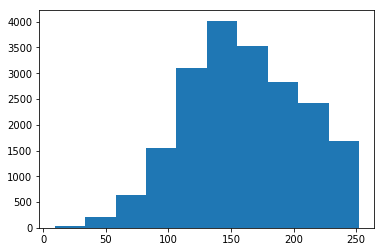

In [19]:
plt.hist(population)
plt.show()

There is nothing "normal" about this distribution, it isn't bell-shaped. So why are we so obsessed with the Normal Distribution?

First, recall that we didn't care so much about the distribution of red pixel levels, but the distribution of differences between the means of two random groups under the null hypothesis. And this distribution, amazingly, did have a bell shape:

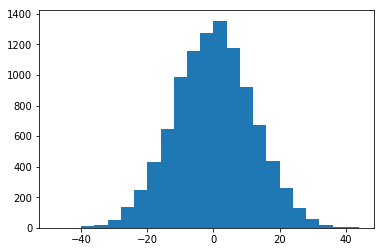

In [8]:
plt.hist(null_mean_diffs, bins = np.arange(-48, 48, 4))
plt.show()

Second, recall that our final metric (for now) is the p-value. We need a way of computing this p-value without having the population at the palm of our hand. The Normal Distribution lets us compute any probability p with just two numbers ($\mu$ and $\sigma$), so it would be very convenient to have a normal Null Distribution.

## The Normal Distribution: Refresher

With Discrete RVs we usually talk about "Probability Mass Function" (PMF).

With Continuous RVs we talk about "Probability Density Function" (PDF).

If $X \sim N(\mu, \sigma^2)$ its desnsity function is defined as:

$f(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{\frac{- ( {x - \mu } )^2 }{2\sigma^2}}$

If $\mu = 0$ and $\sigma = 1$ (a.k.a the Standard Normal Distribution $N(0, 1)$) it has the familiar form:

$f(x) = \frac{1}{{ \sqrt {2\pi } }}\exp(-\frac {x^2}{2})$

and the familiar bell shape around 0:

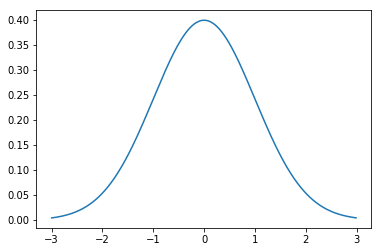

In [10]:
import scipy.stats as stats

x = np.arange(-3, 3, 0.01)
plt.plot(x, stats.norm.pdf(x, 0, 1))
plt.show()

The density function $f(x)$ is a positive real function, the area under which is 1.

But notice that its values are NOT probabilities but densities. Probabilities are *areas*.

And to get those areas (probabilities) we *integrate*:

$P(X \leq a) = \int_{-\infty}^a f(x) \;dx.$

That last function is known as the Cumulative Distribution Function (CDF), $F_X(a)$.

It is used so much in the Standard Normal Distribution that we denote it $\Phi(a) = P(X \leq a)$ when $X\sim N(0,1)$:

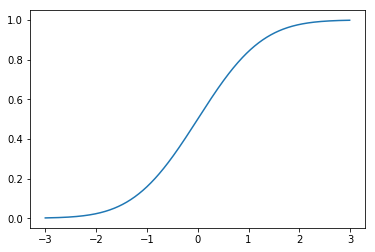

In [22]:
plt.plot(x, stats.norm.cdf(x, 0, 1))
plt.show()

If $X\sim N(\mu, \sigma)$ then you can create $Z\sim N(0, 1)$ by *standardizing*:

$Z = \frac{X - \mu}{\sigma} \sim N(0, 1)$

### $\mu$ and $\sigma$

The pair of parameters $\mu$ and $\sigma$ are enough to define a Normal distribution.

The Normal distribution was parametrized in such a way that $\mu$ and $\sigma$ tell us the most important measures about this distribution, its expectation is $\mu$ and standard deviation is $\sigma$.

Morever, once a RV distributes Normal, we know roughly what percentage of the distribution is within one, two, three standard deviations off the mean, e.g. ~95% of the distribution is within 2 $\sigma$s off the mean:

<img src = 'images/normal_dist.png' width = "50%" height = "50%">

For example, in our Null Distribution of mean differences, which had a bell shape to it:

In [11]:
mu = np.mean(null_mean_diffs)
sigma = np.std(null_mean_diffs)
print(f'Mean of mean differences: {mu: .2f}')
print(f'SD of mean differences: {sigma: .2f}')

Mean of mean differences:  0.08
SD of mean differences:  11.89


We could fit the Normal distribution with these parameters over the histogram, and see if the fit is "good":

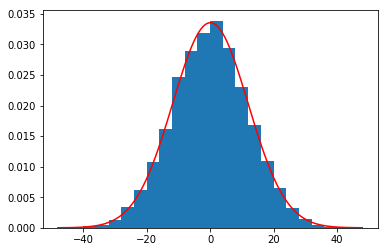

In [12]:
plt.hist(null_mean_diffs, bins = np.arange(-48, 48, 4), density = True)
x = np.arange(-48, 48, 0.01)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color = 'red')
plt.show()

The fit looks "good", and so we could say that 95% of the distribution is within 2 standard deviations off the mean:

In [25]:
print(f'({mu - 2 * sigma: .2f}, {mu + 2 * sigma: .2f})')

(-23.77,  23.68)


Our original samples means difference of 16 points is well within these boundaries.

## Central Limit Theorem (CLT)

The CLT states that for a random sample ${X_1, ..., X_n}$ from a population with mean $E(X) = \mu$ and finite variance $V(X) = \sigma^2$, for large enough sample size $n$:

$\overline{X} \dot{\sim} N(\mu, \frac{\sigma^2}{n})$

Or in oter words:

$\frac{\overline{X} - \mu}{\sigma / \sqrt{n}} \dot{\sim} N(0, 1)$

* $\frac{\sigma}{\sqrt{n}}$ is called the Standard Error (SE) of the mean

* $Z = \frac{\overline{X} - \mu}{\sigma / \sqrt{n}}$ is the Z statistic

This has far reaching implications.

## Bernoulli example

Assume $X_1,...,X_n$ are a random sample, with $X_i\sim Ber(p=0.5)$.

Then $E(X_i) = p= 0.5$ and $Var(X_i) = p(1-p) = 0.25$. 

We know: $\sum_i X_i \sim Bin(n,p=0.5).$

The CLT tells us:
$$ \frac{\sum_i X_i}{n} =  \bar{X} \stackrel{\cdot}{\sim} N(0.5,\frac{0.25}{n}),$$
or: 
$$ \sum_i X_i =  n\bar{X} \stackrel{\cdot}{\sim} N(0.5n,0.25n),$$
if $n$ is big enough. So:
$$ N(0.5n,0.25n) \approx Bin(n,0.5).$$



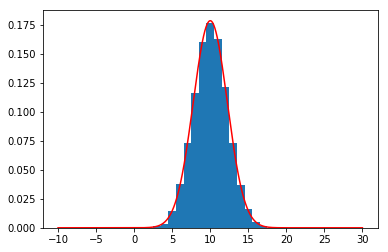

In [25]:

null_res = np.random.binomial(20, 0.5, size=10000)
N, bins, patches = plt.hist(null_res, bins=np.arange(-0.5, 20.5, 1),density = True)
x = np.arange(-10, 30, 0.01)
plt.plot(x, stats.norm.pdf(x, 20/2, (20/4)**(0.5)), color = 'red')
plt.show()


### Exponential Distribution Demo

The Exponential Distribution is another well researched continuous distribution. $X \sim Exp(\lambda)$:

$Supp(X) = [0, \infty]$ (also $\lambda > 0$)

$f(X) = \lambda e^{-\lambda x}$

$F_x(k) = P(X \leq k) = 1 - e^{-\lambda x}$

$E(X) = \frac{1}{\lambda}$

$V(X) = \frac{1}{\lambda^2}$

Example: X is the time between two trains from Tel-Aviv to Haifa which come on average every 20 minutes (1/3 hour). So: $X \sim Exp(3)$

How it looks (definitely not normal):

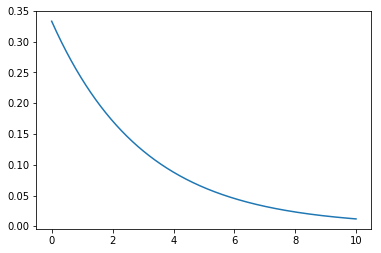

In [26]:
x = np.arange(0, 10, 0.01)
plt.plot(x, stats.expon.pdf(x, scale = 3))
plt.show()

### Exponential Distribution Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 30$:

<img src = "images/clt_exp3_n30.gif">

### Exponential Distribution Demo

A demo where $X \sim Exp(3)$, sampling distribution of the mean with $n = 5$:

<img src = "images/clt_exp3_n5.gif">

## Z-Test

The trains from Tel-Aviv to Haifa come every 20 minutes? (null  hypothesis)

Lately it seems like a lot more. (alternative hypothesis)

I randomly sampled 30 waiting times between two trains, and got an average $\overline{X} = 4/9$ or 26 minutes and 40 seconds.

Under the null hypothesis, the CLT says that: $\overline{X} \dot{\sim} N(\frac{1}{3}, \frac{1/9}{30})$

Or: $\frac{\overline{X} - 1/3}{1/\sqrt{270}} \dot{\sim } N(0, 1)$

We got: $\overline{X} = 4/9$, or $Z = \frac{4/9 - 1/3}{1/\sqrt{270}} = 1.8257$

We can compute a p-value!

In [27]:
one_sided_p_value = 1 - stats.norm.cdf(4/9, 1/3, np.sqrt(1/270))
#or
one_sided_p_value = 1 - stats.norm.cdf(1.8257, 0, 1)

print(f'P(X_bar >= 4/9 | H0) = {one_sided_p_value: .2f}')

P(X_bar >= 4/9 | H0) =  0.03


And this looks pretty extreme (lower than 5%), and we "reject the null hypothesis" and conclude that indeed it seems like the waiting time has increased.

## Back to Girls and Boys Shirts

Let $X$ be the red pixel level of girls shirts images.

Let $Y$ be the red pixel level of boys shirts images.

(They don't have a normal distribution, which is fine). 

Under $H_0$ they both come from the same distribution with $E(X) = E(Y) = \mu$ and $V(X) = V(Y) = \sigma^2$.

Sample size was $n = 30$ for both independent samples.

## Null distribution of the difference in means


So under $H_0$, according to CLT, the sampling distribution for both samples means is Normal: $\overline{X} \stackrel{\cdot}{\sim} N(\mu, \frac{\sigma^2}{n})$, $\overline{Y} \stackrel{\cdot}{\sim} N(\mu, \frac{\sigma^2}{n})$

We were interested in the distribution of the means differences, which we now know should be approximately Normal:

$\overline{X} - \overline{Y} \stackrel{\cdot}{\sim}  N(0, \frac{\sigma^2}{n} + \frac{\sigma^2}{n})$ (make sure you understand why!)

In other words, under $H_0$:

$\frac{\overline{X} - \overline{Y}}{\sqrt{\frac{2 \sigma^2}{n}}} \stackrel{\cdot}{\sim} N(0, 1)$

Only one thing is missing: we do not know what $\sigma$ is (Do we know what $\mu$ is? Why is that not a problem?)

### Girls and Boys Shirts - Z-Test

Let's assume for now we estimate it from the population: $\sigma$ = `np.std(population) = 45.8`.

So under $H_0$: $\overline{X} - \overline{Y} \stackrel{\cdot}{\sim}  N(0, \frac{2\cdot 45.8^2}{30} = 11.84^2)$

Or: $\frac{\overline{X} - \overline{Y}}{11.84} \stackrel{\cdot}{\sim}  N(0, 1)$

And we got: $\overline{X} - \overline{Y} = 16$, or $Z = \frac{16}{11.84} = 1.35$

And we can perform a Z-Test and compute the p-value:

In [28]:
one_sided_p_value = 1 - stats.norm.cdf(16, 0, 11.84)
#or
one_sided_p_value = 1 - stats.norm.cdf(1.35, 0, 1)

print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

P(mean_diff >= 16 | H0) =  0.09


Which is similar to the result we got using our "known population".

## From Z-Test to T-Test

But $\sigma^2$ isn't known!

Solution: replace the unknwon $\sigma^2$ by the unbiased estimator $S^2 = \frac{1}{n - 1}\sum{(X_i - \overline{X})^2}$

For a Standard Normal RV $Z=\frac{\overline{X} - \mu}{\sigma / \sqrt{n}}$, if we replace the unknown $\sigma$  by $S$, we get a new distribution called **Student's t** distribution:

$Z \frac{\sigma}{S} = \frac{\overline{X} - \mu}{S / \sqrt{n}} \sim t_{n - 1}$

This statistic distributes "$t$ with $n - 1$ degrees of freedoms (df)", hence called the T statistic.



The t distribution typically has "longer tails" than the Standard Normal distribution for small $n$, reflecting the added uncertainty once $\sigma$ isn't known but estimated by $S$.

But for $n \geq 120$ it is similar to the Standard Normal:

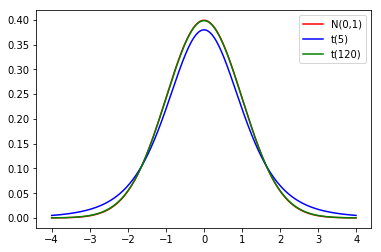

In [29]:
x = np.arange(-4, 4, 0.01)
plt.plot(x, stats.norm.pdf(x, 0, 1), color = 'red')
plt.plot(x, stats.t.pdf(x, 5), color = 'blue')
plt.plot(x, stats.t.pdf(x, 120), color = 'green')
plt.gca().legend(('N(0,1)','t(5)', 't(120)'))
plt.show()

## One Sample T-Test

Again: Under $H_0$, with a large sample $n$, according to CLT: $\frac{\overline{X} - \mu}{\sigma / \sqrt{n}} \sim N(0, 1)$ 

Now the $\sigma$ is unknown. $\mu$ is known under the null hypothesis, often $H_0 : \mu = 0$

We replace $\sigma$ by its estimator: $S = \sqrt{\frac{1}{n_x - 1}\sum{(X_i - \overline{X})^2}}$

We get:

$\frac{\overline{X} - \mu_{H0}}{\sqrt{\frac{S^2}{n}}} \sim t_{n - 1}$

And you can perform a t-test using e.g. `stats.ttest_1samp(x, 0)`.

## Two Independent Samples T-Test

In our kind of problems we have two samples: $X_1,...,X_{n_x}$ and $Y_1,...,Y_{n_y}$. In our case also $n_x=n_y=30$. 

Our Null hypothesis of interest is $H_0: \mu_X = \mu_Y$. We will also assume $\sigma^2_X = \sigma^2_Y$. 

Now, with $n=m=30$ we can use the CLT and write that under $H_0$: 

$\frac{\overline{X} - \overline{Y}}{\sqrt{\sigma^2(\frac{1}{n_x}+\frac{1}{n_y})}} \sim N(0, 1)$ 

Since we do no know $\sigma^2$, but we assume it is equal for both groups under the null, we estimate it: 

$S^2_p = \frac{(n_x - 1)S^2_x + (n_y - 1)S^2_y}{n_x + n_y - 2}$

And the distribution is t with $n_x + n_y - 2$ degrees of freedom:

$\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} \sim t_{n_x+n_y -2}$

This is the solution **assuming the variances are equal**. 



### Unequal Variances Assumed (extra credit)

Now, with $n=m=30$ we can use the CLT and write that under $H_0$: 

$\frac{\overline{X} - \overline{Y}}{\sqrt{(\frac{\sigma^2_X}{n_x}+\frac{\sigma^2_Y}{n_y})}} \sim N(0, 1)$ 

We replace $\sigma_x$ by its estimator: $S_x = \sqrt{\frac{1}{n_x - 1}\sum{(X_i - \overline{X})^2}}$ and the same for $\sigma_y$.

We keep the SE estimator of $\sqrt{\frac{S_x^2}{n_x} +\frac{S_y^2}{n_y}}$:

$\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_x^2}{n_x} +\frac{S_y^2}{n_y}}} \sim t_{df'}$

Where: $df' ={\frac {\left({\frac {s_{1}^{2}}{n_{1}}}+{\frac {s_{2}^{2}}{n_{2}}}\right)^{2}}{{\frac {\left(s_{1}^{2}/n_{1}\right)^{2}}{n_{1}-1}}+{\frac {\left(s_{2}^{2}/n_{2}\right)^{2}}{n_{2}-1}}}}$



### Girls and Boys Shirts - T-Test

Recall the null hypothesis: $H_0: \mu_x = \mu_y$

We will use the equal variances assumed version.

First manually:

In [31]:
S2_x = np.var(girls_red, ddof = 1) # for getting the "n - 1" unbiased estimator of sigma
S2_y = np.var(boys_red, ddof = 1)
n_x = n_y = 30
S2_p = ((n_x - 1)*S2_x + (n_y - 1)*S2_y) / (n_x + n_y - 2)

t_statistic = (np.mean(girls_red) - np.mean(boys_red))/np.sqrt(S2_p/n_x + S2_p/n_y)
print(f'T statistic: {t_statistic: .4f}')

one_sided_p_value = 1 - stats.t.cdf(t_statistic, n_x + n_y - 2)

print(f'P(mean_diff >= 16 | H0) = {one_sided_p_value: .2f}')

T statistic:  1.2191
P(mean_diff >= 16 | H0) =  0.11


Now with Python's built-in function:

In [31]:
stats.ttest_ind(girls_red, boys_red)

Ttest_indResult(statistic=1.2191309822847303, pvalue=0.22772950529997951)

The T statistic is the same, but the p-value is twice the result we got because the Python function always computes the two-sided p-value.

Anyway, p-value of 11% isn't convincing and we do not reject the null hypothesis.

Notice the T-test p-value of 11% is greater than the Z-test p-value of 9%, which makes sense:

Gave up the known variance assumption, added uncertainty (the variance is now in itself a RV), got the t distribution with "heavier" tails, need more extreme values to impress.

## Confidence Intervals (CI)

One (of a few) problem with p-value: it is not informative.

With large enough sample size any result can become "significant" (why?).

Statistical significance is not scientific significance.

Often we would prefer reporting what the actual mean $\mu$ (or means difference $\mu_x - \mu_y$) was, to show it was "interesting". 

But since our sample mean $\overline{X}$ (or sample means difference $\overline{X} - \overline{Y}$) is most probably WRONG, it comes with uncertainty, we report a Confidence Interval:

"$\mu$ is within [10, 20] with 95% level of confidence"

### Building the CI: Z-Test

In general: for a random sample $X$ from distribution with unknown parameter $\theta$, $[LB(X), UB(X)]$ is a $100(1-\alpha)\%$ CI for $\theta$ if $P(LB(X) < \theta < UB(X)) = 1 - \alpha$

Usually: $\alpha = 0.05$ and we would build a *symmetric* CI around some $\hat{X}$ estimator of $\theta$, like $\overline{X}$

For the Z-test:

$P(Z_{2.5} < \frac{\overline{X} - \mu}{\sigma/\sqrt{n}} < Z_{97.5}) = P(\overline{X} + Z_{2.5}\frac{\sigma}{\sqrt{n}} < \mu < \overline{X} + Z_{97.5}\frac{\sigma}{\sqrt{n}}) = 0.95$ where $Z_q$ is the $q$th precentile of the $N(0, 1)$ distribution

$\implies [\overline{X} + Z_{2.5}\frac{\sigma}{\sqrt{n}}\;,\; \overline{X} + Z_{97.5}\frac{\sigma}{\sqrt{n}}]$ or $\overline{X} \pm 1.96\frac{\sigma}{\sqrt{n}}$ is a 95% CI for $\mu$

### CI for Waiting Time for Train

Recall: Under $H_0$ $X \sim Exp(3)$ so: $\sigma = \frac{1}{3}$

We got: $\overline{X} = \frac{4}{9}; \space n = 30;$

95% CI for $\mu$:

In [32]:
LB = 4/9 - stats.norm.ppf(0.975) * (1/3)/np.sqrt(30)
UB = 4/9 + stats.norm.ppf(0.975) * (1/3)/np.sqrt(30)
print(f'[{LB: .3f}, {UB: .3f}]')

[ 0.325,  0.564]


Most common misconception of CI: "The probability that $\mu$ is within [0.33, 0.56] is 95%"
    
No. $\mu$ is either within the CI or not, $\mu$ is a parameter, not a RV!

But what *does* it mean?

### CI for Mean Demo

A demo where $X \sim Exp(3)$, confidence interval for the mean with $n = 30$:

<img src = "images/ci_exp3_n30.gif">

### CI for Mean Demo

A demo where $X \sim Exp(3)$, confidence interval for the mean with $n = 5$:

<img src = "images/ci_exp3_n5.gif">

### Building the CI: T-Test

For One-Sample T-Test:

$[\overline{X} + t_{n-1;2.5}\;\frac{S}{\sqrt{n}}, \overline{X} + t_{n-1;97.5}\;\frac{S}{\sqrt{n}}]$ or $\overline{X} \pm t_{n-1,97.5}\;frac{S}{\sqrt{n}}$ is a 95% CI for $\mu$

For Two-Samples T-Test, equal variances assumed:

$[(\overline{X} - \overline{Y}) + t_{n_x+n_y-2;2.5}\;\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}\;,\; (\overline{X} - \overline{Y}) + t_{n_x+n_y-2;97.5}\;\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}]$ or $(\overline{X} - \overline{Y}) \pm t_{n_x+n_y-2,97.5}\;\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}$ is a 95% CI for $\mu$

### Girls and Boys Shirts - Confidence Interval for Means Difference

Recall we got: $\overline{X} - \overline{Y} = 16; \space n_x = 30; \space n_y = 30; S^2_p = 2574$

95% CI for $\mu_x - \mu_y$:

In [33]:
LB = (np.mean(girls_red) - np.mean(boys_red)) - stats.t.ppf(0.975, n_x + n_y - 2) * np.sqrt(S2_p/n_x + S2_p/n_y)
UB = (np.mean(girls_red) - np.mean(boys_red)) + stats.t.ppf(0.975, n_x + n_y - 2) * np.sqrt(S2_p/n_x + S2_p/n_y)
print(f'[{LB: .1f}, {UB: .1f}]')

[-10.3,  42.2]


## Power

If we take the "true" means difference of the red level pixel in girls shirts images "population" vs. boys:

In [32]:
true_mean_diff = np.mean(girls_red_all) - np.mean(boys_red_all)
print(f'True means difference: {true_mean_diff: .2f}')

True means difference:  7.06


Surprise: it *is* in fact higher, by 7 points.

Let's assume for the time being that this is "interesting" (is it, though?).

It turns out the null hypothesis, which we have not rejected, was wrong.

Girls shirts *are* "redder".

Why did we fail to reject the null hypothesis, and would likely fail again?

We lacked Statistical Power: the probability of correctly rejecting the null hypothesis when the null is false, when the alternative is actually the case.

### Girls and Boys Shirts - Power Analysis - Simulation

$P(\mbox{reject }H_0 | H_1) = ?$

Let's simulate before we compute. We have the "population", we can just take many girls and boys samples, perform a T-test and see the percentage of times we reject the null hypothesis, i.e. p-value < $\alpha$:

In [34]:
def random_sample_t_test(alpha, n):
    boys_red_sample = np.random.choice(boys_red_all, n)
    girls_red_sample = np.random.choice(girls_red_all, n)
    t_test = stats.ttest_ind(girls_red_sample, boys_red_sample)
    return (girls_red_sample.mean() > boys_red_sample.mean() and t_test[1]/2 < alpha)

n_simulations = 10000
n = 30
alpha = 0.05

rejections = [random_sample_t_test(alpha, n) for i in range(n_simulations)]

print(f'Power = P(reject H0 | H1) = {np.mean(rejections): .2f}')

Power = P(reject H0 | H1) =  0.14


With 14% power, it seems only about 1 in 7 samples would have caught our 7 points difference and reject $H_0$!

### Girls and Boys Shirts - Power Analysis - Computation

In a realistic situation we do not know that $H_0$ should be rejected. We do not know the 7 points "true" difference. And we cannot sample 10,000 times from the population.

A common approach is to estimate statistical power for different "true" differences or "effect size".

If we assume that $H_0$ should be rejected and the true difference is 7 points:

$P(reject H_0 | H_1) = P(\mbox{ getting  pvalue }< \alpha | \mbox{true  mean difference is  7  points}) = ?$

$P(\frac{\overline{X} - \overline{Y} - 0}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} > t_{n_x+n_y-2;95}| \mu_x -\mu_y = 7) =$

$P(\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y) + (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} > t_{n_x+n_y-2;95}| \mu_x -\mu_y = 7) =$

$P(\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} > t_{n_x+n_y-2;95} - \frac{(\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}}| \mu_x -\mu_y = 7) =$

$1 - P(\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} < t_{n_x+n_y-2;95} - \frac{(\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}}| \mu_x -\mu_y = 7) =$

In [35]:
t_c = stats.t.ppf(0.95, n_x + n_y - 2)
power = 1 - stats.t.cdf(t_c - 7/np.sqrt(S2_p/n_x + S2_p/n_y), n_x + n_y - 2)
print(f'Power = P(reject H0 | H1) = {power: .2f}')

Power = P(reject H0 | H1) =  0.13


In [38]:
# with Python's built-in method:
from statsmodels.stats.power import TTestIndPower
effect = 7/np.sqrt(S2_p) # true means difference divided by S_p
power = TTestIndPower().power(effect_size = effect, nobs1 = 30, alpha = 0.05, ratio = 1, alternative = 'larger')
print(f'Effect size = {effect : .2f}  Power = P(reject H0 | H1) = {power: .2f}')

Effect size =  0.14  Power = P(reject H0 | H1) =  0.13


### Type I and Type II Errors

We've mentioned that the "Level of Confidence" is often written as $1 - \alpha$, where $\alpha$ is "Type I Error".

Statistical power is often written as $1 - \beta$, where $\beta$ is "Type II Error".

The meaning of these terms is often better understood in a table:

| Reality\Decision | Not Reject $H_0$    | Reject $H_0$   |
|---|------|-----|
| $H_0$ | Confidence: $1 - \alpha$ | Type I Error: $\alpha$ |
| $H_1$ |  Type I Error: $\beta$    | Power: $1 - \beta$    |

Or in a graph:

<img src = "images/power_curves.png">

### What affects Power?

From our final calculation:

$1 - P(\frac{\overline{X} - \overline{Y} - (\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}} < t_{n_x+n_y-2;1-\alpha} - \frac{(\mu_x - \mu_y)}{\sqrt{\frac{S_p^2}{n_x} +\frac{S_p^2}{n_y}}}| \mu_x -\mu_y = 7)$

* True Difference $\mu_x - \mu_y = \delta$

* Standard deviation $\sigma$, as estimated by $S_p$ (usually combined with true difference to create a standardized effect size: $\frac{\mu_x - \mu_y}{\sigma}$). In our case: $7.06/S_p = 0.14$.

* Sample size $n_x, n_y$ (many times the go-to parameter for researchers to increase power)

* Type I Error $\alpha$ (usually untouched!)

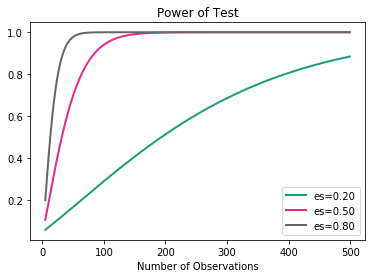

In [37]:
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 500))
TTestIndPower().plot_power(dep_var = 'nobs', nobs = sample_sizes, effect_size = effect_sizes)
plt.show()

### Caution!

Statistical significance is not scientific significance. The tiniest, uninteresting, effect size, can be "discovered" with a large enough sample size. 

Example: Assume in our case study we have an overall difference of 0.5 in red value, instead of 7, so effect size is $0.5/S_p \approx 0.01$. 

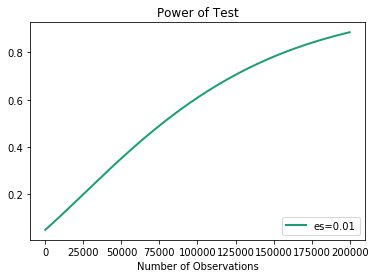

In [84]:
effect_sizes = np.array([0.01])
sample_sizes = np.array(range(5, 200000))
TTestIndPower().plot_power(dep_var = 'nobs', nobs = sample_sizes, effect_size = effect_sizes)
plt.show()